In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
from keras.layers import Dense, Dropout

# Get Data

make sampling even

1. reduce the dataset (253680,) by sampling a smaller size (50736 rows)
2. min-max scale the features to account for different ranges in data like BMI
3. add an intercept bias term to features
4. split into training/test data

**Note**: diabetes_012 has three classes
- 0: no diabetes or only during pregnancy
- 1: prediabetes
- 2: diabetes

In [128]:
df = pd.read_csv('../archive/diabetes_012_health_indicators_BRFSS2015.csv')

# columns should be type int -- none are float or categorical
df = df.astype(int)
print(df.shape)

# reduce dataset by sampling 
df_small = df.sample(frac=0.2, random_state=1)
df_small.shape

df_balanced = pd.read_csv('../archive/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df_balanced = df_balanced.astype(int)

(253680, 22)


In [133]:
def getTrainTestData(df, y_label, test_size=0.25):
    """
    Splits the data into train and test sets.
    """

    # Split the data into features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label].to_numpy()

    # min max scaling, rounded to 3 decimal places
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X).round(3)
    # Add a new column filled with ones -- for intercept/bias term
    X_scale = np.hstack((X_scale,np.ones([X_scale.shape[0],1], X_scale.dtype)))

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=1)

    return X_train, X_test, y_train, y_test

In [134]:
X_train_small, X_test_small, y_train_small, y_test_small = getTrainTestData(df_small, 'Diabetes_012')
X_train_big, X_test_big, y_train_big, y_test_big = getTrainTestData(df, 'Diabetes_012')
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = getTrainTestData(df_balanced, 'Diabetes_binary')

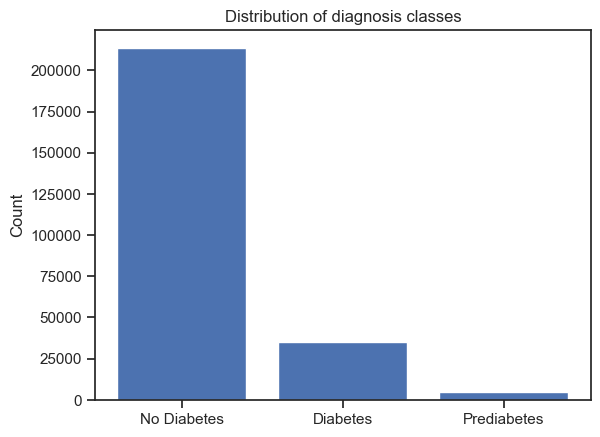

In [ ]:
# the distribution of classes. As you can see, the dataset is not balanced
counts = df['Diabetes_012'].value_counts()
classes = ['No Diabetes', 'Prediabetes', 'Diabetes']
plt.bar(counts.index.map(lambda x: classes[x]), counts.values)

# df['Diabetes_012'].value_counts().plot(kind='bar')
plt.title('Distribution of diagnosis classes')
plt.ylabel('Count')
plt.show()


# Exploratory DA

I'm trying to find the most important features

In [ ]:

import random

In [112]:
no_diabetes = df_small.loc[df_small['Diabetes_012'] == 0, :]
pre_diabetes = df_small.loc[df_small['Diabetes_012'] == 1, :]
diabetes = df_small.loc[df_small['Diabetes_012'] == 2, :]

In [114]:
df_small.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

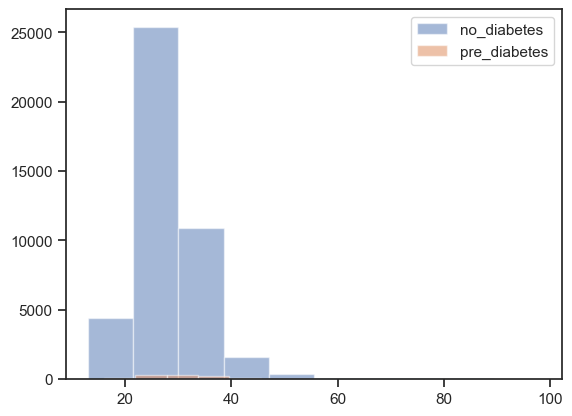

In [119]:
bins = np.linspace(-10, 10, 100)

plt.hist(no_diabetes['BMI'], alpha=0.5, label='no_diabetes')
plt.hist(pre_diabetes['BMI'], alpha=0.5, label='pre_diabetes')
# plt.hist(diabetes['BMI'], alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.show()

In [106]:
sns.histplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

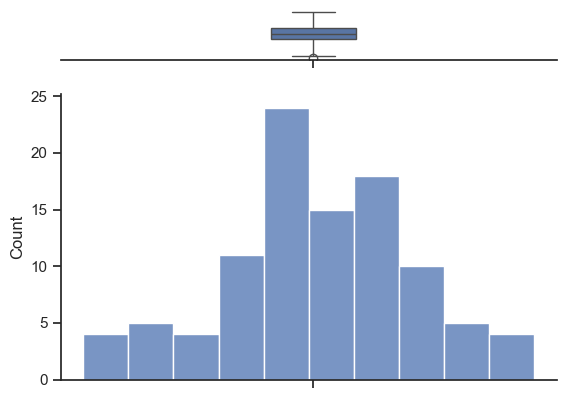

In [105]:
x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box, )
sns.histplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

# MLP

## sklearn

- ~45 seconds to fit: 300 iterations, 1 hidden layer size 100

Loss function

ADAM:
- 0.847, hidden = (50,)
- 0.848 , hidden = (15,)
- 0.846, hidden = (20,10,)
- 0.848, hidden = (20), batch_size=50 --> 20 seconds to train also

WITH BALANCED DATASET: 2 classes
- .74

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [75]:
clf = MLPClassifier(
    random_state=1, 
    max_iter=300,
    batch_size=50,
    hidden_layer_sizes=(20),
    learning_rate='invscaling',
                    ).fit(X_train_small, y_train_small)

In [76]:
clf.predict_proba(X_test[:1])
clf.predict(X_test[:5, :])
clf.score(X_test, y_test)

0.8554394954670871

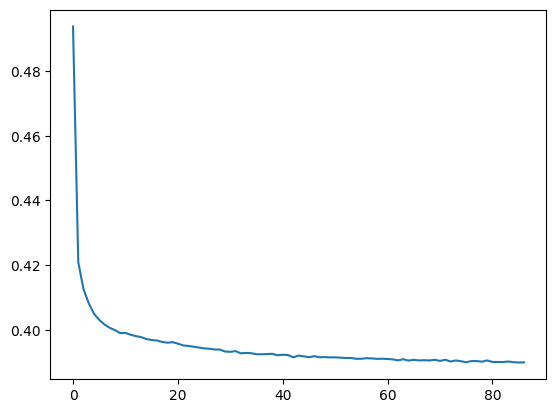

In [77]:
# plot the loss curve
plt.plot(clf.loss_curve_)

In [ ]:
print(clf.predict_proba(X_test[:1]))
print(clf.predict(X_test[:5, :]))
print(clf.score(X_test, y_test))

In [13]:
clf.classes_

array([0, 1, 2])

In [14]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## keras

### small dataset:

---
**Accuracy: 0.8488273024559021**

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_p, epochs=10, batch_size=32)

---

**Accuracy: 0.8508356809616089**

model = keras.Sequential([
    Dense(10, activation='relu', input_shape=(22,)),
    Dense(5, activation='relu', input_shape=(10,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

**Accuracy: 0.8521759510040283**
model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [158]:
y_train_p = keras.utils.to_categorical(y_train_small, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_small, num_classes=3)

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test_small, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1190/1190 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7732 - loss: 0.5872
Epoch 2/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8411 - loss: 0.4188
Epoch 3/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8425 - loss: 0.4169
Epoch 4/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8417 - loss: 0.4116
Epoch 5/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.8429 - loss: 0.4075
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.8586 - loss: 0.3825


0.8521759510040283

In [160]:
# plot the confusion matrix
def plot_confusion_matrix(y_actual, y_pred, labels):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


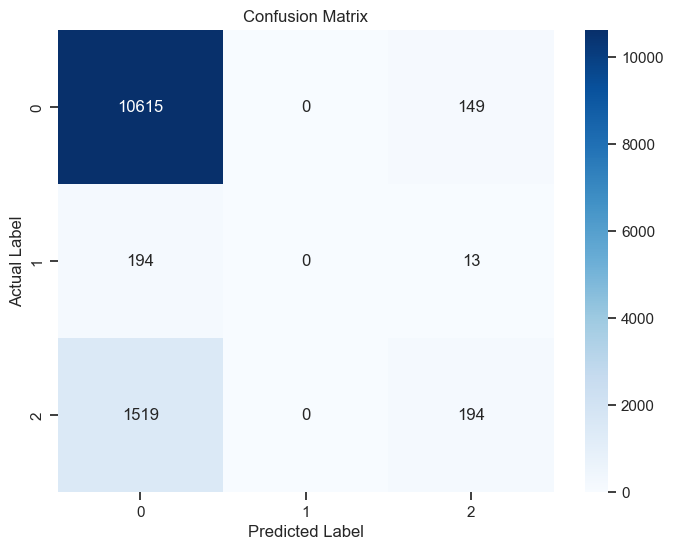

In [162]:
y_prob = model.predict(X_test_small) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_small, y_classes, labels=[0, 1, 2])

## balanced dataset

---

**Accuracy: 0.7466757297515869**

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_balanced, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [172]:
y_train_p = keras.utils.to_categorical(y_train_balanced, num_classes=2)
y_test_p = keras.utils.to_categorical(y_test_balanced, num_classes=2)

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_balanced, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test_balanced, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1657/1657 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6526 - loss: 0.6327
Epoch 2/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1000us/step - accuracy: 0.7357 - loss: 0.5366
Epoch 3/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7383 - loss: 0.5294
Epoch 4/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.7430 - loss: 0.5199
Epoch 5/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7460 - loss: 0.5130
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.7449 - loss: 0.5115


0.7466757297515869

553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step


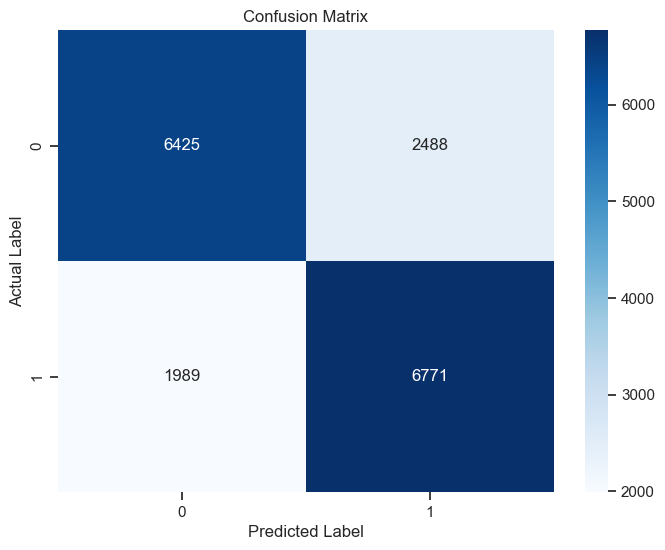

In [ ]:
y_prob = model.predict(X_test_balanced) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_balanced, y_classes, labels=[0, 1])

'''
This confusion matrix looks a lot better, especially for predicting diabetes.
'''

# Scale to larger dataset

In [ ]:
y_train_p = keras.utils.to_categorical(y_train_big, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_big, num_classes=3)

model = keras.Sequential([
    Dense(5, activation='relu', input_shape=(22,)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)
loss, accuracy = model.evaluate(X_test_big, y_test_p)
# predictions = model.predict(new_data)
accuracy

Epoch 1/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 5s 980us/step - accuracy: 0.7402 - loss: 0.7158
Epoch 2/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8434 - loss: 0.4157
Epoch 3/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8448 - loss: 0.4083
Epoch 4/4
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 4s 909us/step - accuracy: 0.8472 - loss: 0.4026
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.8441 - loss: 0.4024


0.8468345999717712

In [122]:
y_prob = model.predict(X_test_big) 
y_classes = y_prob.argmax(axis=-1)

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step


In [125]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

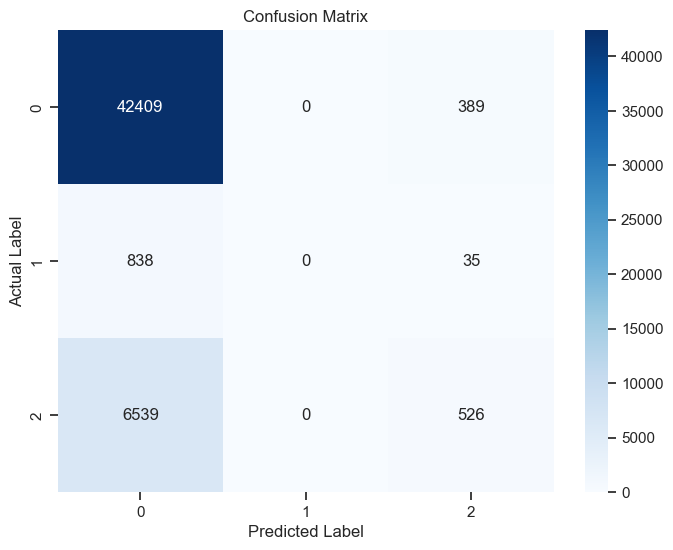

In [ ]:
plot_confusion_matrix(y_test_big, y_classes, labels=[0, 1, 2])

'''
So basically, we do not correctly predict the pre-diabetes class at all.
- The model predicts most of the pre-diabetes class as no diabetes.
The model is also really bad at predicting diabetes. which is obviously worse
'''